In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
df = pd.read_csv('gold_2021.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns=["Volume", "Open", "Oil Close", "CAD Close", "Low", "High"])
df

,Gold Close,TSX Close,Bar Close
Date,,,
2010-01-04,1117.699951,11866.900391,35.995537
2010-01-05,1118.099976,11888.099609,36.337681
2010-01-06,1135.900024,11944.500000,36.936466
2010-01-07,1133.099976,11887.500000,36.474537
2010-01-08,1138.199951,11953.799805,36.560101
...,...,...,...
2021-01-14,1850.300049,17958.099609,29.910000
2021-01-15,1829.300049,17909.000000,29.459999
2021-01-19,1839.500000,17957.400391,29.809999


In [4]:
df_input = df
df_output = df[["Bar Close"]]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.3, random_state=42, shuffle= False)

In [6]:
x_train.shape

(1887, 3)

In [7]:
x_test.shape

(810, 3)

In [8]:
x_test

,Gold Close,TSX Close,Bar Close
Date,,,
2017-09-21,1290.599976,15454.900391,19.391613
2017-09-22,1293.300049,15454.200195,19.430107
2017-09-25,1306.800049,15516.200195,19.766932
2017-09-26,1297.000000,15474.099609,19.516718
2017-09-27,1283.400024,15609.700195,19.516718
...,...,...,...
2021-01-14,1850.300049,17958.099609,29.910000
2021-01-15,1829.300049,17909.000000,29.459999
2021-01-19,1839.500000,17957.400391,29.809999


In [9]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)

y_train_scaler.fit(y_train)
y_test_scaler.fit(y_test)

x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(x_test)

y_train = y_train_scaler.transform(y_train)
y_test = y_test_scaler.transform(y_test)


In [28]:
length = 30
batch = 44
features = 3

train_generator = TimeseriesGenerator(x_train, y_train, length=length, sampling_rate=30, batch_size=batch)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, sampling_rate=30, batch_size=batch)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [30]:
model = Sequential()
units = 64
drop = 0.2

#1st layer
model.add(LSTM(units=units, return_sequences=True, input_shape=(length, features)))
model.add(Dropout(drop))

#2nd layer
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(drop))

#3rd layer
model.add(LSTM(units=units))
model.add(Dropout(drop))

# Output layer
model.add(Dense(1))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            17408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [32]:
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs["val_loss"]
        if val_loss < self.threshold:
            self.model.stop_training = True

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

earlystop = ThresholdCallback(threshold=0.0022)

model.compile(optimizer="adam", loss="mean_squared_error")


fit = model.fit_generator(train_generator, epochs = 50, validation_data=test_generator,
                         shuffle=False, callbacks=[earlystop])

Epoch 1/50


ValueError: Error when checking input: expected lstm_3_input to have shape (30, 3) but got array with shape (1, 3)

In [19]:
model.evaluate_generator(test_generator, verbose=0)

0.0015856410536798649

In [20]:
predictions = model.predict_generator(test_generator)

In [21]:
predicted_prices = y_test_scaler.inverse_transform(predictions)
real_prices = y_test_scaler.inverse_transform(y_test[1:].reshape(-1,1))

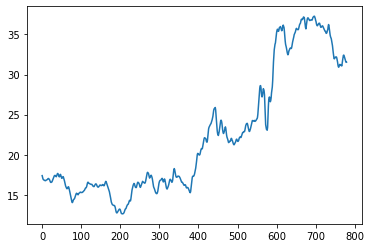

In [27]:
plt.plot(predicted_prices)


In [ ]:
stocks.plot(title=f"Barricks Actual Vs. Predicted Prices MSE: 0.00061")
plt.savefig('BarrickDay.png')

In [ ]:
stocks["diff"] = stocks["Real"] - stocks["Predicted"]
stocks["diff"].mean()

In [ ]:
min(fit.history["val_loss"])

In [ ]:
stocks["pct real"] = stocks["Real"].pct_change() 
stocks["pct pred"] = stocks["Predicted"].pct_change()
stocks["pos real"] = np.where(stocks['pct real'] > 0, 1, 0)
stocks["pos pred"] = np.where(stocks['pct pred'] > 0, 1, 0)
stocks["test"] = abs(stocks["pos pred"] - stocks["pos real"])
stocks['test'].sum()

In [ ]:
prediction = stocks["Predicted"].loc["2021-01-20"]
prediction

In [ ]:
stocks